In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Get a balanced sample of 5 songs per genre

In [3]:
num_genres = song_data.Genre.nunique()

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(50)
song_data

,Genre,Lyrics
245316,Country,"She took my love, She wore it down And it look..."
232124,Country,Everybody I know is a looking for love but the...
242655,Country,Well if I had a dollar for every time you let ...
246070,Country,You got out with no bruises or scratches You b...
238838,Country,(Chalee Tennison/Dale Dodson/Billy Lawson) Her...
...,...,...
30632,Rock,"take,\ntake all you need\nand I'll compensate ..."
37928,Rock,What a dream I had\nPressed in organdy\nClothe...
233982,Rock,"This is only a test One,two, whatcha gunna do ..."
52404,Rock,"We old ones, have seen two wars\nWhen you're s..."


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield simple_preprocess(str(sentence), deacc=True)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Apply tokenization and remove stopwords
song_data_processed['Tokens'] = remove_stopwords(sent_to_words(song_data_processed['Lyrics']))
song_data_processed

,Genre,Lyrics,Tokens
245316,Country,she took my love she wore it down and it looke...,"[took, love, wore, looked, good, town, ill, ok..."
232124,Country,everybody i know is a looking for love but the...,"[everybody, know, looking, love, know, give, e..."
242655,Country,well if i had a dollar for every time you let ...,"[well, dollar, every, time, let, stood, gave, ..."
246070,Country,you got out with no bruises or scratches you b...,"[got, bruises, scratches, broke, free, visible..."
238838,Country,(chalee tennison/dale dodson/billy lawson) her...,"[chalee, tennison, dale, dodson, billy, lawson..."
...,...,...,...
30632,Rock,take\ntake all you need\nand i'll compensate y...,"[take, take, need, compensate, greed, broken, ..."
37928,Rock,what a dream i had\npressed in organdy\nclothe...,"[dream, pressed, organdy, clothed, crinoline, ..."
233982,Rock,this is only a test onetwo whatcha gunna do th...,"[test, onetwo, whatcha, gunna, three, four, fi..."
52404,Rock,we old ones have seen two wars\nwhen you're si...,"[old, ones, seen, two, wars, sick, afraid, dan..."


In [9]:
# Create a dictionary and a corpus for each song
corpora = []
dictionaries = []
lda_models = []
topics = []
dominant_topics = []

num_topics = num_genres  # Change this to the desired number of topics

for i, tokens in enumerate(song_data_processed['Tokens']):
    # Create Dictionary
    id2word = gensim.corpora.Dictionary([tokens])

    # Create Corpus
    corpus = [id2word.doc2bow(tokens)]

    corpora.append(corpus)
    dictionaries.append(id2word)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lda_models.append(lda_model)

    # Get the most dominant topic for each song
    song_topics = lda_model.get_document_topics(corpus[0], minimum_probability=0.0)
    dominant_topic = max(song_topics, key=lambda x: x[1])[0]

    song_topics = list(map(lambda x: x[1], song_topics))
    
    dominant_topics.append(dominant_topic)
    topics.append(song_topics)

# Add the 'topics_words' column to the DataFrame
song_data_processed['Topics'] = topics
song_data_processed['Dominant_Topic'] = dominant_topics
song_data_processed

,Genre,Lyrics,Tokens,Topics,Dominant_Topic
245316,Country,she took my love she wore it down and it looke...,"[took, love, wore, looked, good, town, ill, ok...","[0.0016393525, 0.0016397213, 0.0016393525, 0.0...",8
232124,Country,everybody i know is a looking for love but the...,"[everybody, know, looking, love, know, give, e...","[0.0010869848, 0.0010869848, 0.0010872736, 0.9...",3
242655,Country,well if i had a dollar for every time you let ...,"[well, dollar, every, time, let, stood, gave, ...","[0.0007937771, 0.0007937187, 0.00079366175, 0....",4
246070,Country,you got out with no bruises or scratches you b...,"[got, bruises, scratches, broke, free, visible...","[0.0011628651, 0.0011628103, 0.98953444, 0.001...",2
238838,Country,(chalee tennison/dale dodson/billy lawson) her...,"[chalee, tennison, dale, dodson, billy, lawson...","[0.0013333557, 0.0013333755, 0.0013333714, 0.0...",4
...,...,...,...,...,...
30632,Rock,take\ntake all you need\nand i'll compensate y...,"[take, take, need, compensate, greed, broken, ...","[0.0011111739, 0.0011111498, 0.0011111608, 0.0...",9
37928,Rock,what a dream i had\npressed in organdy\nclothe...,"[dream, pressed, organdy, clothed, crinoline, ...","[0.0021280502, 0.0021276886, 0.9808502, 0.0021...",2
233982,Rock,this is only a test onetwo whatcha gunna do th...,"[test, onetwo, whatcha, gunna, three, four, fi...","[0.0011905036, 0.0011905036, 0.0011905036, 0.0...",6
52404,Rock,we old ones have seen two wars\nwhen you're si...,"[old, ones, seen, two, wars, sick, afraid, dan...","[0.9897726, 0.0011363758, 0.0011363758, 0.0011...",0


### Explore Results

#### Crosstab

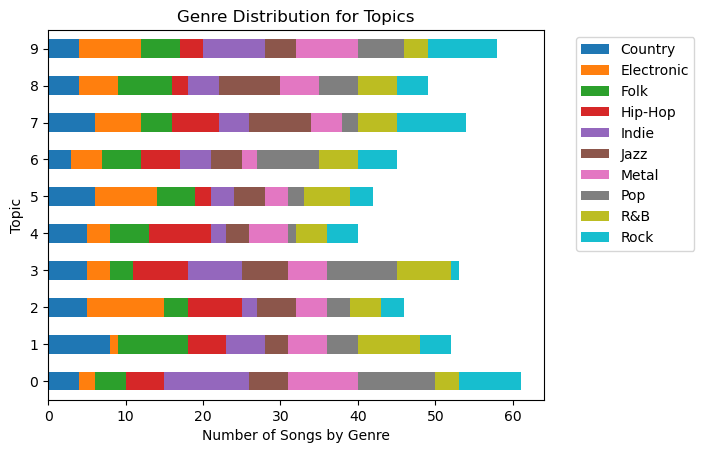

In [10]:
# Create a crosstab
crosstab = pd.crosstab(song_data_processed['Dominant_Topic'], song_data_processed['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

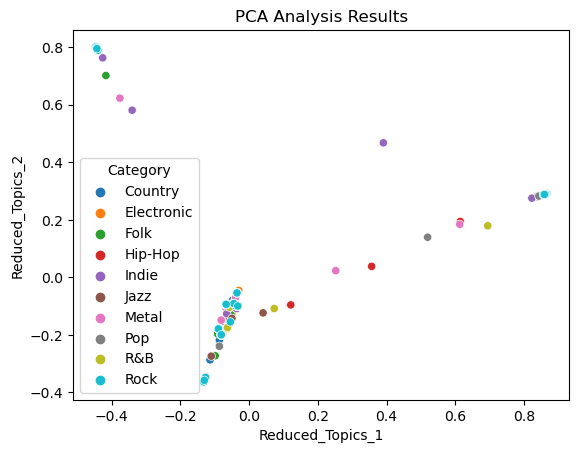

In [11]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(song_data_processed["Topics"].to_list())
#song_data_processed["Reduced_Topics"] = reduced.tolist()
song_data_processed[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=song_data_processed)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [12]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(song_data_processed["Topics"].tolist())
song_data_processed["Cluster"] = kmeans.labels_
song_data_processed

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Genre,Lyrics,Tokens,Topics,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
245316,Country,she took my love she wore it down and it looke...,"[took, love, wore, looked, good, town, ill, ok...","[0.0016393525, 0.0016397213, 0.0016393525, 0.0...",8,-0.088433,-0.178222,5
232124,Country,everybody i know is a looking for love but the...,"[everybody, know, looking, love, know, give, e...","[0.0010869848, 0.0010869848, 0.0010872736, 0.9...",3,-0.063330,-0.177277,9
242655,Country,well if i had a dollar for every time you let ...,"[well, dollar, every, time, let, stood, gave, ...","[0.0007937771, 0.0007937187, 0.00079366175, 0....",4,-0.035347,-0.055037,8
246070,Country,you got out with no bruises or scratches you b...,"[got, bruises, scratches, broke, free, visible...","[0.0011628651, 0.0011628103, 0.98953444, 0.001...",2,-0.033000,-0.101102,6
238838,Country,(chalee tennison/dale dodson/billy lawson) her...,"[chalee, tennison, dale, dodson, billy, lawson...","[0.0013333557, 0.0013333755, 0.0013333714, 0.0...",4,-0.035224,-0.054836,8
...,...,...,...,...,...,...,...,...
30632,Rock,take\ntake all you need\nand i'll compensate y...,"[take, take, need, compensate, greed, broken, ...","[0.0011111739, 0.0011111498, 0.0011111608, 0.0...",9,-0.442860,0.794750,2
37928,Rock,what a dream i had\npressed in organdy\nclothe...,"[dream, pressed, organdy, clothed, crinoline, ...","[0.0021280502, 0.0021276886, 0.9808502, 0.0021...",2,-0.032803,-0.100292,6
233982,Rock,this is only a test onetwo whatcha gunna do th...,"[test, onetwo, whatcha, gunna, three, four, fi...","[0.0011905036, 0.0011905036, 0.0011905036, 0.0...",6,-0.066881,-0.094463,3
52404,Rock,we old ones have seen two wars\nwhen you're si...,"[old, ones, seen, two, wars, sick, afraid, dan...","[0.9897726, 0.0011363758, 0.0011363758, 0.0011...",0,0.859306,0.287566,1


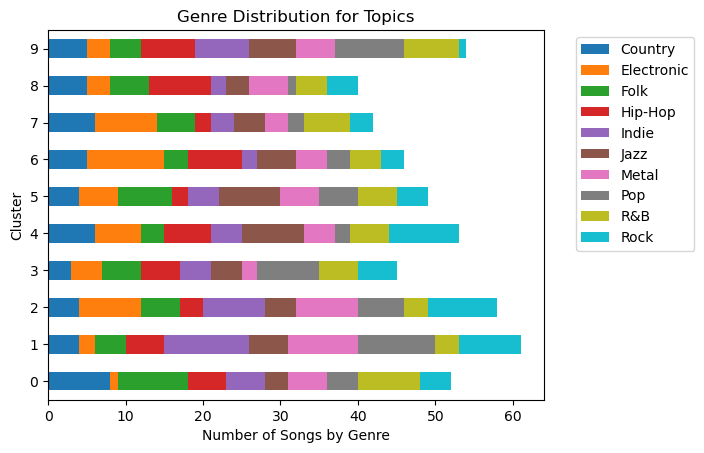

In [13]:
# Create a crosstab
crosstab = pd.crosstab(song_data_processed['Cluster'], song_data_processed['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

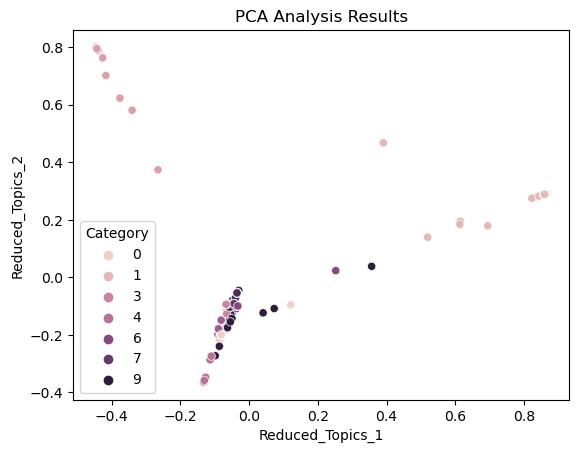

In [14]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=song_data_processed)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [15]:
X = song_data_processed["Topics"].tolist()
label_encoder = LabelEncoder()
song_data_processed["GenreID"] = label_encoder.fit_transform(song_data_processed["Genre"])
y = song_data_processed["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [16]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.1

In [17]:
#svm classifier
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.12

In [18]:
#Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.14

### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic for each song
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Keine offensichtliche Korrelation zwischen genres und Topics in allen Untersuchungen

### Vermutung
Fehler bei der Implementierung. In diesem Notebook wurde für jedes Lied ein eigenes LDA Model trainiert. Deshalb sind die Ergebnisse nicht vergleichbar. Ein zielführenderer Ansatz wäre es, ein Modell zunächst auf der gesamten Song Basis zu trainieren und anschließend die Topic vektoren der Einzelnen Songs aus diesem Modell zu generieren.